## 📝 Project Description
This project uses Stable Diffusion v1.5 to generate high-quality images from text prompts
with optimized speed and performance. It includes various acceleration techniques and
user-friendly functions for different use cases.

## 🚀 Features
- Fast model loading with xformers optimizations
- Specialized functions for quick and high-quality generation
- Automatic saving with smart file naming
- Automatic memory cleanup
- Direct image display in Jupyter/Colab
- Multiple generation modes (quick, quality, portrait)

## Import Libraries and Device Setup

In [1]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image
import os
from datetime import datetime
import gc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")



device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
if device == "cuda":
    torch.cuda.empty_cache()

## Model Loading Function with Speed Optimizations

In [2]:
def load_sd15_model():
    print("Loading Stable Diffusion v1.5...")

    model_id = "runwayml/stable-diffusion-v1-5"

    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16,
        safety_checker=None,
        requires_safety_checker=False,
        use_safetensors=True,
        variant="fp16"
    )

    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

    pipe = pipe.to(device)

    if device == "cuda":
        pipe.enable_attention_slicing()
        pipe.enable_model_cpu_offload()

        try:
            pipe.enable_xformers_memory_efficient_attention()
            print("xformers enabled for acceleration")
        except Exception as e:
            print("xformers not available, continuing without it")

    try:
        pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead")
        print("Model compiled for speed")
    except Exception as e:
        print("PyTorch compile not available")

    print("Model loaded successfully with all optimizations")
    return pipe

In [ ]:
pipe = load_sd15_model()

## Output Directory Setup

In [ ]:
output_dir = "sd15_generated_images"
os.makedirs(output_dir, exist_ok=True)
print(f"Output folder created: {output_dir}")

## Main Image Generation Function

In [5]:
def generate_fast_image(prompt, negative_prompt="", num_steps=20, guidance_scale=7.5, save_image=True):
    print(f"Generating image for: '{prompt}'")
    if negative_prompt:
        print(f"Negative prompt: '{negative_prompt}'")

    if device == "cuda":
        torch.cuda.empty_cache()

    with torch.no_grad(), torch.autocast(device):
        result = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            num_inference_steps=num_steps,
            guidance_scale=guidance_scale,
            width=512,
            height=512,
            generator=torch.Generator(device=device).manual_seed(42)
        )

        image = result.images[0]

    file_path = None
    if save_image:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        safe_prompt = "".join(c if c.isalnum() or c in (' ', '-', '_') else '' for c in prompt)[:25]
        safe_prompt = safe_prompt.replace(' ', '_')
        file_path = os.path.join(output_dir, f"{safe_prompt}_{timestamp}.jpg")

        image.save(file_path, "JPEG", quality=95)
        print(f"Image saved at: {file_path}")

    if device == "cuda":
        torch.cuda.empty_cache()

    return image, file_path

## Display image

In [6]:
def display_image(image):
    from IPython.display import display
    display(image)

## First Test Generation

In [ ]:
test_prompt = "a majestic dragon flying over a medieval castle at night"
test_negative = "blurry, bad quality, distorted"


start_time = datetime.now()
image1, saved_path = generate_fast_image(
    prompt=test_prompt,
    negative_prompt=test_negative,
    num_steps=15,
    guidance_scale=7.5
)

end_time = datetime.now()
generation_time = (end_time - start_time).total_seconds()

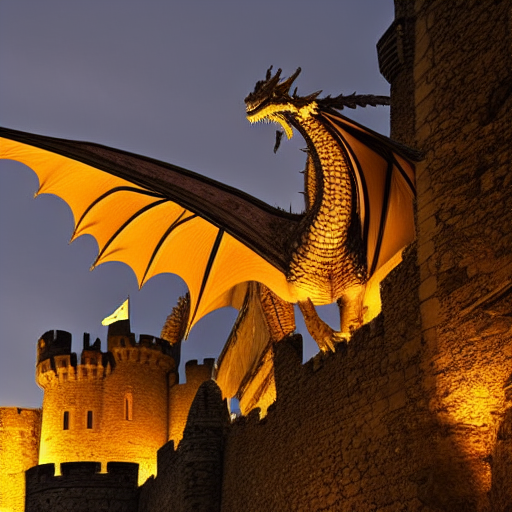

In [8]:
display_image(image1)

## Second Test Generation (Without Negative Prompt)

In [ ]:
test_prompt = "a majestic dragon flying over a medieval castle at night"

start_time = datetime.now()
image2, saved_path = generate_fast_image(
    prompt=test_prompt,
    num_steps=15,
    guidance_scale=7.5
)

end_time = datetime.now()
generation_time = (end_time - start_time).total_seconds()


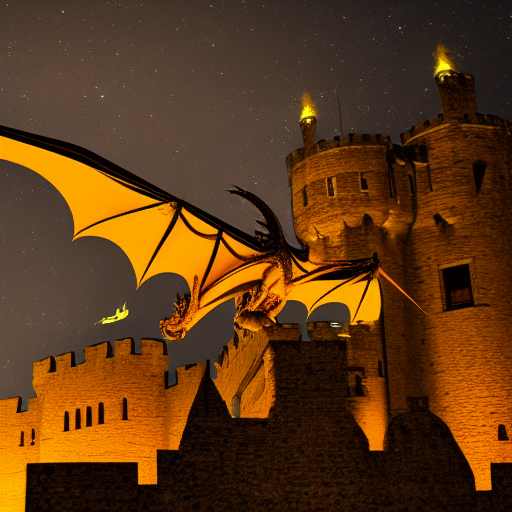

In [10]:
display_image(image2)

## Convenience Functions for Different Use Cases

In [11]:
def quick_generate(prompt, negative="blurry, bad quality", steps=15):
    return generate_fast_image(prompt, negative, steps, 7.5, True)

def quality_generate(prompt, negative="blurry, bad quality", steps=25):
    return generate_fast_image(prompt, negative, steps, 7.5, True)

def portrait_generate(prompt, negative="blurry, bad quality, distorted face"):
    full_prompt = f"portrait of {prompt}, highly detailed, sharp focus, professional photography"
    return generate_fast_image(full_prompt, negative, 20, 8.0, True)

In [ ]:
img1, path1 = quick_generate("a cat sitting in a garden")
img2, path2 = quality_generate("ancient Egyptian pyramids under a starry night sky")
img3, path3 = portrait_generate("a wise old man with a long white beard and gentle smile")

## Display Results in Grid Layout

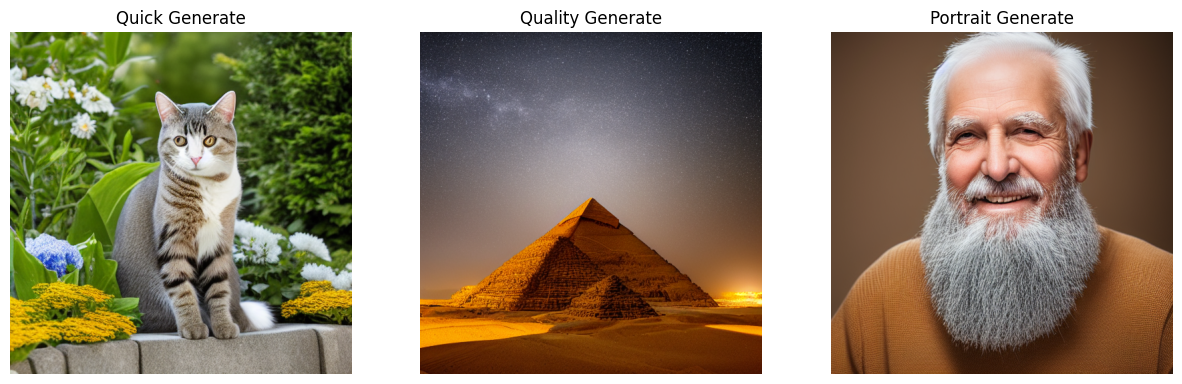

In [13]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.axis("off")
plt.title("Quick Generate")

plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.axis("off")
plt.title("Quality Generate")

plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.axis("off")
plt.title("Portrait Generate")

plt.show()

## Image Generator with Gradio

In [ ]:
import gradio as gr

def generate_images(prompt, num_images=1):
    file_paths = []
    images = []
    for i in range(num_images):
        image, path = generate_fast_image(
            prompt=prompt,
            negative_prompt="blurry, bad quality, distorted",
            num_steps=20,
            guidance_scale=7.5,
            save_image=True
        )
        file_paths.append(path)
        images.append(image)
    return images

with gr.Blocks(css="body {background-color:#f8f9fa;}") as demo:
    gr.Markdown("<h1 style='text-align:center;'>🖼️ Image Generator</h1>")
    
    with gr.Row():
        with gr.Column(scale=1):
            prompt = gr.Textbox(label="Prompt", placeholder="e.g. a futuristic city skyline", lines=2)
            num_images = gr.Slider(label="Number of Images", minimum=1, maximum=4, step=1, value=1)
            generate_btn = gr.Button("Generate", variant="primary")
        
        with gr.Column(scale=2):
            gallery = gr.Gallery(label="Generated Images", show_label=False, columns=2, height="auto")
    
    generate_btn.click(fn=generate_images, inputs=[prompt, num_images], outputs=gallery)

demo.launch(share=True)
